# Problem Set 3: Network analysis of drug target data

Due: Monday, February 22nd, 2021, at 11:59pm

Submission: Please submit your completed Jupyter notebook, with code and written answers, to Canvas, with the filename pset3_SUNET (replacing SUNET with your SUNET ID). Please compile your notebook into web (.html) or document (.pdf) formats, making sure your lines of code/ouput don't get truncated (especially in the PDF!).

Developing a novel disease therapeutic can cost billions of dollars. A key step in drug development is to identify new compounds or FDA-approved drugs as potential disease treatments. Sometimes we understand the biological pathways associated with a given disease, and are looking for compounds that modulate specific targets. In these cases, we would like to develop computational approaches that decrease the cost of identifying drugs by inferring compound-target relationships through the use of publicly available data. This problem set will be an exercise in inferring novel compound indications using data from [Drug Target Commons](https://drugtargetcommons.fimm.fi/) (DTC), a crowd-sourced database of compound–target interaction profiles. 

First, we will create a network of compound-target relationships. Next we will perform basis network analysis, quantifying the centrality of nodes and identifying communities. Finally, we will walk you through the process of training a predictive model for inferring novel compound indications using an embedded representation of the graph.

In [1]:
import sys
print(sys.executable)
sys.path

!{sys.executable} -m pip install python-louvain
!{sys.executable} -m pip install node2vec

/Users/joshuatanner/miniconda3/bin/python3


## Part 1: Generating the network

### 1.1 IC50 values
DTC records a variety of measures of compound-target bioactivity. We are providing you with all entries that include a measurement of [IC50](https://en.wikipedia.org/wiki/IC50) in the file *DTC_IC50.csv*. What is IC50? Why would a high IC50 value indicate that the compound likely cannot be used to inhibit the target?

YOUR WRITTEN ANSWER TO 1.1 HERE

IC50 is the half maximal inhibitory concentration, or the concentration of a drug that can reduce a biological process by 50%. A high IC50 value indicates that in order to achieve a 50% reduction, high amounts of the drug need to be administered, which is suboptimal.

### 1.2 Identify positive and negative compound-target pairs
Our first step is to use the IC50 values for each compound-target pair to determine if the compound can be used to inhibit the target. Some compound-target pairs have been assayed many times and therefore have many IC50 values recorded. Generate a list of compound-target pairs whose median IC50 value is <1000NM. These will be our positive hits. Generate another list of compound-target pairs whose median IC50 value is >= 5000NM. These will be our negative hits (in other words these compounds can not be effectively used to modulate the target). How many positive and negative hits do we have in our dataset?

We will use the following columns from the csv file:
 - compound_id
 - target_id
 - standard_value (this is the IC50 value)
 - compound_name (see Q1.5)
 - gene_names (see Q1.5)

In [2]:
# YOUR CODE FOR 1.2 HERE
import pandas as pd
from itertools import islice
import statistics

# Read in data to df, Trim out unneeded columns
total = pd.read_csv('data/DTC_IC50.csv',
                    usecols=['compound_id', 'target_id', 'standard_value', 'compound_name', 'gene_names'])
print(total[:10])

# Dictionary of compound-target pairs {(compound_id, target_id): [IC50 value(s)]}
ct_pairs = {}
for ind in total.index:
    comp_targ = (total['compound_id'][ind], total['target_id'][ind])
    if comp_targ in ct_pairs:
        ct_pairs[comp_targ].append(total['standard_value'][ind])
    else:
        ct_pairs[comp_targ] = [total['standard_value'][ind]]
        
sanity = list(islice(ct_pairs.items(), 10))
print(f"\n\n\n compound-target pairs dict:\n{sanity}")


pos_hits = []
neg_hits = []

# Clean up the above dict
for key, value in ct_pairs.items():
    # If multiple values, change to median
    if len(value) > 1:
        median = statistics.median(value)
        ct_pairs[key] = median
    else:
        ct_pairs[key] = value[0]
    # List of negative hits
    if ct_pairs[key] >= 5000:
            neg_hits.append(key)
    # List of positive hits
    if ct_pairs[key] < 1000:
        pos_hits.append(key)

        
sanity2 = list(islice(ct_pairs.items(), 10))
print(f"\n\n\n cleaned up compound-target dict:\n{sanity2}")

# Report length of both lists ^
print(f"\nneg_hits len: {len(neg_hits)}")
print(f"\npos_hits len: {len(pos_hits)}")
print(f"\ntotal pairs: {len(ct_pairs)}")

     compound_id compound_name target_id gene_names  standard_value
0  CHEMBL3545284  CERDULATINIB    Q9UHD2       TBK1            10.0
1  CHEMBL3545284  CERDULATINIB    Q9UHD2       TBK1            10.0
2  CHEMBL3545284  CERDULATINIB    Q9R117        NaN             0.5
3  CHEMBL3545284  CERDULATINIB    Q9P0L2      MARK1            10.0
4  CHEMBL3545284  CERDULATINIB    Q9P0L2      MARK1            10.0
5  CHEMBL3545284  CERDULATINIB    Q62137        NaN             8.0
6  CHEMBL3545284  CERDULATINIB    Q12851     MAP4K2            18.0
7  CHEMBL3545284  CERDULATINIB    Q08881        ITK           194.0
8  CHEMBL3545284  CERDULATINIB    Q08881        ITK           194.0
9  CHEMBL3545284  CERDULATINIB    Q00342        NaN            90.0



 compound-target pairs dict:
[(('CHEMBL3545284', 'Q9UHD2'), [10.0, 10.0]), (('CHEMBL3545284', 'Q9R117'), [0.5]), (('CHEMBL3545284', 'Q9P0L2'), [10.0, 10.0]), (('CHEMBL3545284', 'Q62137'), [8.0]), (('CHEMBL3545284', 'Q12851'), [18.0]), (('CHEMBL35452

### 1.3 Build the network
Build a network of compound-target interactions using only the positive hits. We recommend using [networkx](https://networkx.github.io), since it is compatible with another Python package we will use in section 3. How many nodes and edges are in the graph?

There are some great [tutorials](https://networkx.github.io/documentation/stable/tutorial.html) on networkx that you can read to start building your networks!

In [3]:
# YOUR CODE FOR 1.3 HERE
!{sys.executable} -m pip install networkx
import networkx as nx
import matplotlib.pyplot as plt

# Create sets for both
pos_comps = set([pair[0] for pair in pos_hits])
pos_targs = set([pair[1] for pair in pos_hits])
# Combine both sets for a total set of nodes
nodes = pos_comps | pos_targs

# Create our graph, nodes and edges
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(pos_hits)

# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"number of nodes: {num_nodes}\nnumber of edges: {num_edges}")

number of nodes: 231524
number of edges: 307130


### 1.4 Add node types
To improve the descriptiveness of our network, let's add an attribute of "type" to each node to indicate whether the node is a compound or a target. Print the number of nodes of each type.

The function [set_node_attributes](https://networkx.github.io/documentation/stable/reference/generated/networkx.classes.function.set_node_attributes.html) and [get_node_attributes](https://networkx.github.io/documentation/stable/reference/generated/networkx.classes.function.get_node_attributes.html) will be helpful

In [4]:
# YOUR CODE FOR 1.4 HERE
# Compound dict {node: attribute}
comp_dict = {comp : "compound" for comp in pos_comps}
targ_dict = {targ : "target" for targ in pos_targs}
node_types = {**comp_dict, **targ_dict}
print(targ_dict)
# Assign types to nodes
nx.set_node_attributes(G, node_types, "type")

# Print number of nodes of each type
type_dict = nx.get_node_attributes(G, "type")
num_targs = sum(value == "target" for value in type_dict.values())
num_comps = sum(value == "compound" for value in type_dict.values())

print(f"compound nodes: {num_comps}\ntarget nodes: {num_targs}")

{'O35491': 'target', 'B4URF0': 'target', 'Q04756': 'target', 'P00772': 'target', 'P31213': 'target', 'E1BN64': 'target', 'P07861': 'target', 'P52663': 'target', 'P08263': 'target', 'Q63449': 'target', 'Q8I2S7': 'target', 'Q62986': 'target', 'Q99466': 'target', 'P24941': 'target', 'P49187': 'target', 'P53609': 'target', 'Q29010': 'target', 'P11167': 'target', 'P56109': 'target', 'P68400': 'target', 'Q03164': 'target', 'O14842': 'target', 'P15127': 'target', 'Q8NCG7': 'target', 'Q13509': 'target', 'P10398': 'target', 'Q9Z0U4': 'target', 'P06797': 'target', 'Q9UIF8': 'target', 'P15169': 'target', 'Q8N5S9': 'target', 'P51450': 'target', 'Q01432': 'target', 'P30098': 'target', 'P42230': 'target', 'O00142': 'target', 'Q9Y5S8': 'target', 'P00736': 'target', 'Q29463': 'target', 'O08914': 'target', 'P41252': 'target', 'P32358': 'target', 'Q9GZQ6': 'target', 'P17948': 'target', 'Q9WMX2': 'target', 'O95382': 'target', 'P31939': 'target', 'P42677': 'target', 'Q13490': 'target', 'Q8RLA6': 'target',

compound nodes: 228488
target nodes: 3036


### 1.5 Add node names
Now add an attribute "name" to each node using compound_name and gene_names from the DTC_IC50.csv file.

In [5]:
# YOUR CODE FOR 1.5 HERE

gene_names = pd.Series(total.gene_names.values, total.target_id.values).to_dict()
drug_names = pd.Series(total.compound_name.values, total.compound_id.values).to_dict()
names = {**gene_names, **drug_names}

nx.set_node_attributes(G, names, "name")

## Part 2: Exploring the network

### 2.1 Degree distribution
Plot a histogram showing the degree distribution of our graph. It might be helpful to log-scale the y-axis. Why are there so many nodes with degree 1?

Hint: the [degree](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html) function will be helpful

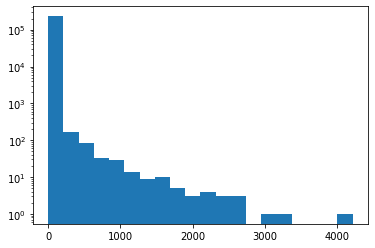

In [6]:
# YOUR CODE FOR 2.1 HERE
import numpy as np

degrees = list(G.degree())
_, degree_list = zip(*degrees)

plt.hist(degree_list, bins=20, log=True)
plt.show()

YOUR WRITTEN ANSWER TO 2.1 HERE

So many nodes have one degree because compounds can only be connected to targets, and there is an immense mismatch between those two groups in terms of numbers.

### 2.2a Filter compounds by degree
Remove all compounds with degree == 1 from the graph. Print out the number of nodes and edges that remain, along with the number of compounds vs targets. Why might it be useful to filter out these very low degree compounds (think about the goal of this pset)?

In [7]:
# YOUR CODE FOR 2.2A HERE

# Create list of nodes with a degree of one, then remove.
remove = [node for node, degree in dict(G.degree()).items() if degree == 1]
G.remove_nodes_from(remove)

print(f"total nodes: {G.number_of_nodes()}\ntotal edges: {G.number_of_edges()}")

# Print number of nodes of each type
type_dict = nx.get_node_attributes(G, "type")
num_targs = sum(value == "target" for value in type_dict.values())
num_comps = sum(value == "compound" for value in type_dict.values())

print(f"compound nodes: {num_comps}\ntarget nodes: {num_targs}")

total nodes: 55086
total edges: 130876
compound nodes: 52536
target nodes: 2550


YOUR WRITTEN ANSWER TO 2.2A HERE

Since we are trying to build a model that will eventually be able to predict a compound-target relationship, there really isn't much to be learned or otherwise inferred from those nodes which only have a degree of one.

### 2.2b Remove isolates
By removing compounds with degree == 1, we may have left some targets as isolates (not connected to any other nodes in the graph). Remove all isolates from the graph. Print out the number of nodes and edges that remain, along with the number of compounds vs targets. 

Hint: the [isolates](https://networkx.org/documentation/stable//reference/algorithms/isolates.html) function may be helpful

In [8]:
# YOUR CODE FOR 2.2B HERE

# Remove the isolate nodes not connected to anything
G.remove_nodes_from(list(nx.isolates(G)))

print(f"total nodes: {G.number_of_nodes()}\ntotal edges: {G.number_of_edges()}")

# Print number of nodes of each type
type_dict = nx.get_node_attributes(G, "type")
num_targs = sum(value == "target" for value in type_dict.values())
num_comps = sum(value == "compound" for value in type_dict.values())

print(f"compound nodes: {num_comps}\ntarget nodes: {num_targs}")

total nodes: 54711
total edges: 130876
compound nodes: 52531
target nodes: 2180


### 2.3 Connected components
What is a [connected component](https://en.wikipedia.org/wiki/Connected_component_(graph_theory))? How many are there in our graph? See [here](https://networkx.org/documentation/stable/reference/algorithms/component.html) for helpful networkx functions.

In [9]:
# YOUR CODE FOR 2.3 HERE
print(f"number of connected components: {nx.number_connected_components(G)}")

number of connected components: 152


YOUR WRITTEN ANSWER TO 2.3 HERE

In my own words, a connected component of a graph is essentially a subgraph consisting of nodes which are all linked through a series of edges, but these edges do not connect to other nodes or components of the graph.

### 2.4 Visualize part of the network
Visualize the component containing the target P29375 (name=KDM5A). Color compounds in red and targets in yellow. Also display names for the targets. Use the networkx [draw](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw) function.

To help us with grading, please set the positioning of your visualization as follows:
```
pos = nx.spring_layout(subG, seed=888)
nx.draw(subG, pos=pos, ... any additional parameters)
```

To color your nodes, you can refer to this [post](https://stackoverflow.com/questions/13517614/draw-different-color-for-nodes-in-networkx-based-on-their-node-value) for help.

Tip: Setting the edge color to gray instead of black makes it easier to read the node labels.

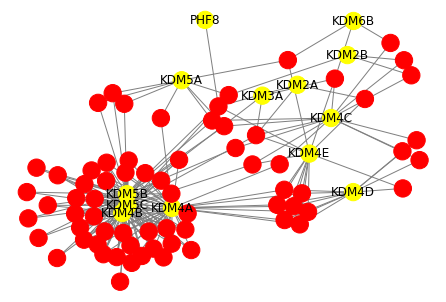

In [10]:
# YOUR CODE FOR 2.4 HERE
from itertools import count

# Get a list of the nodes in subgroup with 'P29375'
connect_nodes = nx.node_connected_component(G, 'P29375')
# Create network with that list
subG = G.subgraph(connect_nodes)

# Create a list of colors that exactly matches the order of nodes in the subnetwork
mapping = {'compound': 'red', 'target': 'yellow'}
nodes = subG.nodes()
colors = [mapping[subG.nodes[n]['type']] for n in nodes]

# Create a dictionary {target node: target name} to be used for labeling
targs = {k : v['name'] for k,v in subG.nodes(data=True) if v['type'] == 'target'}

# Draw the network
pos = nx.spring_layout(subG, seed=888)
nx.draw(subG, pos=pos, node_color=colors, edge_color='gray', labels=targs)
plt.show()

### 2.5a Normalized degree centrality

We want to detect important nodes in our network. One way to characterize an important node is by *normalized degree centrality*, calculated for each node by dividing the number of neighbors by the total number of possible neighbors.

For this exercise, we want you to **hand-code** *normalized degree centrality* for our network and to set the *normalized degree centrality* as an attribute of your node. You may not use any predefined *degree_centrality* functions.

(HINT: remember that we are working with a bipartite graph. Think about the number of possible neighbors for each node.)

In [11]:
def normalized_degree_centrality(G, m, node):
    # INPUT:
    ## G: network
    ## m: number of possible neighbors
    ## node: node of interest to calculate degree centrality
    
    num_neighs = len(list(G.neighbors(node)))
    ndc = num_neighs / m
    return ndc

# set the normalized_degree_centrality for each node

# List of targets and compounds
targs = [x for x, y in G.nodes(data=True) if y['type']=='target']
comps = [x for x, y in G.nodes(data=True) if y['type']=='compound']

# for targ in targs, append normalized_degree_centrality(G, len(comps), targ) to list of ndc
targ_ndc = {targ : normalized_degree_centrality(G, len(comps), targ) for targ in targs}
comp_ndc = {comp : normalized_degree_centrality(G, len(targs), comp) for comp in comps}
all_ndc = {**targ_ndc, **comp_ndc}

nx.set_node_attributes(G, all_ndc, "ndc")

### 2.5b Normalization 

We see that normalized degree centrality depends on normalizing the number of neighbors by dividing by the total number of possible neighbors. How might this score be misleading? (HINT: Think in terms of the inbalance between the number of compounds & targets and experimental selection bias)

Plot a histogram of the distributions of normalized degree centrality colored by *type*. Please use the *density=True* and *log=True* attributes for the function. Why are the distributions so different?

You can refer to this [post](https://stackoverflow.com/questions/23617129/matplotlib-how-to-make-two-histograms-have-the-same-bin-width) for help with plotting two histograms in the same plot

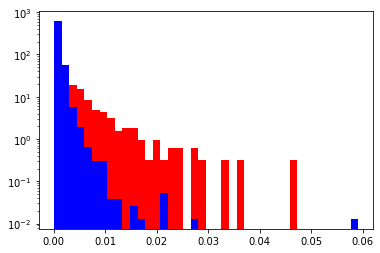

In [12]:
# YOUR CODE FOR 2.5B HERE

#Create separate lists of ndc values for targets and compounds
targ_ndc = [y['ndc'] for x, y in G.nodes(data=True) if y['type']=='target']
comp_ndc = [y['ndc'] for x, y in G.nodes(data=True) if y['type']=='compound']

# Plot ndc values for each group by color
bins = np.histogram(np.hstack((targ_ndc,comp_ndc)), bins=40)[1] #get the bin edges
plt.hist(targ_ndc, bins, label='target', color='red', density=True, log=True)
plt.hist(comp_ndc, bins, label='compound', color='blue', density=True, log=True)

plt.show()

YOUR WRITTEN ANSWER FOR 2.5B HERE
The ndc would only have meaning for a compound in the context of other compounds, or for a target in the context of other targets. The imbalance in numbers means that target nodes will naturally have a far higher ndc than targets. Additionally, the numbers are better representations of past experimental results, rather than on reality. For instance, a given compound may be highly important but rank low on ndc simply because little work has been done on it.

### 2.6 Betweeness centrality

*Betweeness centrality* is another method for determining important nodes in our network. While degree centrality only looks at directly connected edges, the betweeness centrality measures the importance of each node for holding the network together. It calculates the fraction of shortest paths that pass through a particular node. We will not make you code this part up since, as you can imagine, calculating shortest paths can be computationally expensive and requires optimization! For this part, use the [betweeness centrality algorithm for bipartite graphs](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.centrality.betweenness_centrality.html) from the networkx package to calculate betweenness centrality for the component containing 'P29375' (not the entire graph). Set betweeness_centrality as an attribute of each node in the component.

In [13]:
# YOUR CODE FOR 2.6 HERE

# Need a list of all the nodes in ONE group of the bipartite graph. 
# Here I randomly chose the targets but compounds would have worked fine.
targ_subnodes = [x for x, y in subG.nodes(data=True) if y['type'] == 'target']

# calculate betweeness centrality and make an attribute of the nodes in subG
btwn = nx.algorithms.bipartite.centrality.betweenness_centrality(subG, targ_subnodes)
nx.set_node_attributes(subG, btwn, "betweenness_centrality")

### 2.7 Compare degree centrality and betweeness
Draw two plots of the component containing 'P29375' with targets labeled. Color one using degree centrality and the other using betweenness. Compare the two metrics - do they pick out the same nodes? How can a node have high betweeness but not degree centrality and vice versa? Note that we do not expect these two metrics to be on the same scale in this case since we computed one over the entire graph and one only over a connected component.

Hint: You can draw both plots using the same layout by first fixing the layout, and then passing it into the networkx draw method like this...

```
pos = nx.spring_layout(subG, seed=888)
nx.draw(subG, pos=pos, ... any additional parameters)
```

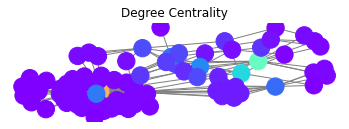

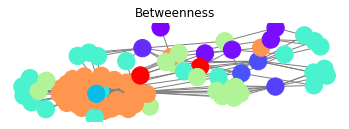

In [14]:
# YOUR CODE FOR 2.7 HERE

# Plot degree centrality
plt.subplot(2,1,1)
plt.title('Degree Centrality')
pos = nx.spring_layout(subG, seed=888)
ndc2color = list(nx.get_node_attributes(subG,'betweenness_centrality').values())
nx.draw(subG, pos=pos, node_color=ndc2color, edge_color='gray', cmap=plt.cm.get_cmap('rainbow'))
plt.show()

# Plot betweenness
plt.subplot(2,1,2)
plt.title('Betweenness')
pos = nx.spring_layout(subG, seed=888)
btwn2color = list(nx.get_node_attributes(subG,'ndc').values())
nx.draw(subG, pos=pos, node_color=btwn2color, edge_color='gray', cmap=plt.cm.get_cmap('rainbow'))
plt.show()

YOUR WRITTEN ANSWER FOR 2.7 HERE

Degree centrality is more short-sighted, only seeing one node away. The targets are going to be the ones with lots of compounds attached to them and thus will be the hot nodes. Betweenness centrality is able to look farther and give an idea of the weight that each node bears in holding the network together. In this case, we see that now compounds can have high values, and that certain targets that were high in degree centrality actually prove to not be so vital to the structure of the network.

### 2.8 Functional interpretation
Print out the compound in the full graph with the largest degree centrality. Print the genes associated with targets of this compound (we stored this information as the "name" of the targets). Input the associated genes into [Reactome Pathway Analysis](https://reactome.org/PathwayBrowser/#TOOL=AT) to find the functional pathways of these genes. Include a screenshot of the pathway browser output. Explain what functions the compound likely modulates.

In [15]:
# YOUR CODE FOR 2.8 HERE

# Compound with highest ndc
comp_ndc = {x:y['ndc'] for x, y in G.nodes(data=True) if y['type'] == 'compound'}
big_ndc = max(comp_ndc.keys(), key=(lambda k: comp_ndc[k]))
print(f"Compound with largest degree centrality: {big_ndc}")

# List of all target neighbors of big_ndc compound
id_neighs = set(x for x in list(G.neighbors(big_ndc)))
# Get a list of the gene names for each neighbor instead of id's
gene_neighs = [y['name'] for x, y in G.nodes(data=True) if x in id_neighs]
# Get rid of NaN values
gene_neighs = [x for x in gene_neighs if isinstance(x, str)]

print(f"\n\nGene neighbors of compound: {len(gene_neighs)}\n")
for gene in gene_neighs:
    print(gene, sep ='' + '\n')


Compound with largest degree centrality: CHEMBL388978


Gene neighbors of compound: 117

CDK2
CDK3
CDK6
LTK
MET
EPHB4
AKT1
MAPKAPK2
PDPK1
STK3
FLT1
MAPK1
PTK2
INSR
EPHA1
PRKACA
PTK6
MUSK
ERBB4
MYLK
PKN1
FYN
PRKCD
ERBB2
NTRK2
EPHA2
MAPK14
PRKCA
CSK
GSK3B
MAP3K5
RET
JAK3
ACVRL1
JAK2
RPS6KA1
AKT3
MAP3K7
CDK1
FGFR4
KDR
EPHA3
AURKA
EGFR
FES
KIT
PRKCH
ROS1
ROCK1
MST1R
FLT4
PLK2
ITK
NUAK1
FGFR1
CHEK2
DAPK1
TEK
MAP2K1
PDGFRA
EPHB1
PRKG1
MINK1
CYP11B2
AURKB
PRKCE
LYN
CDK9
CDK4
ABL2
FGFR2
TYK2
BRAF
GSK3A
YES1
FER
AKT2
PIM2
LRRK2
LCK
ZAP70
SYK
BTK
PRKCG
AXL
NTRK1
PAK2
PIM1
PRKCB
ALK
ABL1
CAMK2A
RPS6KA5
KARS
STK17B
PLK1
TYRO3
IKBKB
RPS6KB1
CSF1R
SGK1
PRKCI
PKN2
JAK1
FLT3
IGF1R
CHEK1
RAF1
CHUK
EPHB2
FGFR3
MERTK
CDK5
TNIK
IRAK4
PDGFRB
SRC


YOUR WRITTEN ANSWER FOR 2.8 HERE

It appears that the major pathways involved include the immune system, disease pathways, and signal transduction. My best guess is that the compound may be some sort of autoimmune or cancer agent.


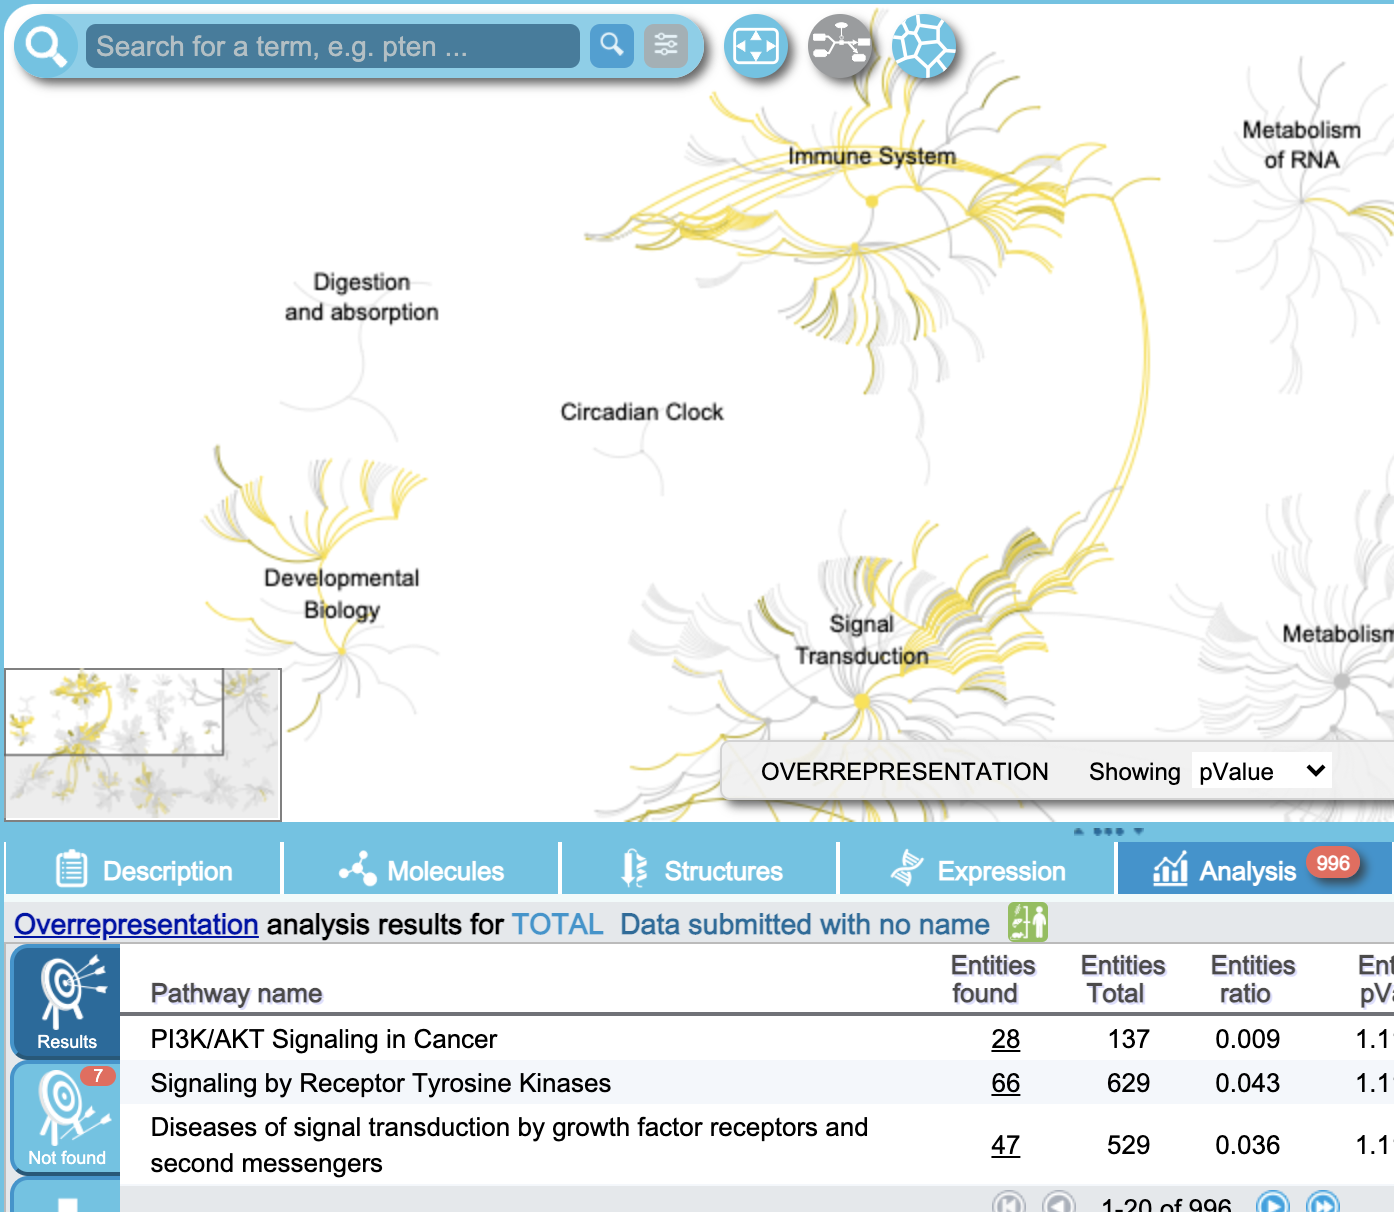

### 2.9 Community detection

Instead of looking at specific compounds or targets, we can also look at communities of nodes that are tightly connected. We will be using the Louvain algorithm [1] for community detection.

For networkx, we recommend you use the *community* package (https://python-louvain.readthedocs.io/en/latest/)

[1] Fast unfolding of communities in large networks, Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Renaud Lefebvre, Journal of Statistical Mechanics: Theory and Experiment 2008(10), P10008 (12pp)

For this exercise, please run louvain community detection over the full graph, using randomize=False (to help us with grading). Store the results as an attribute of each node. How many communities does the algorithm detect?

In [16]:
# YOUR CODE FOR 2.9 HERE
import community as community_louvain

partition = community_louvain.best_partition(G, randomize=False)

# Set community number as attribute
nx.set_node_attributes(G, partition, "community")
# Find total communities
num_com = max(set(v for k,v in partition.items()))
print(f"number of communities: {num_com}")

number of communities: 232


## 3 Network Embedding
Network embeddings assign nodes in a network to points in Euclidean space while still preserving network structure. This allows us to visualize the network in a new way and provides a feature space that is amenable to traditional machine learning. Node2vec [1] is a commonly used network embedding algorithm. We will use node2vec to generate feature representations for the edges in our graph. Then we will train a logistic regression model to predict new compound-target interactions.

[1] node2vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. 

### 3.1 Prepare a subgraph
Our graph is large, so for the purposes of this pset, let's focus on the louvain community containing compound CHEMBL388978. We have provided CHEMBL388978_edges.txt, which contains the edges for the louvain community containing compound CHEMBL388978. Note that this file only contains  positive (ICD < 1000NM) edges. Read in the file and use it to generate a network using networkx. We will use this network for the rest of the assignment.

In [17]:
# YOUR CODE FOR 3.1 HERE

# Capture our nodes
community = partition['CHEMBL388978']
h_nodes = [k for k,v in partition.items() if v == community]

# Capture our edges
edge_doc = open('data/CHEMBL388978_edges.txt', 'r')
pairs = set()
for line in edge_doc:
    pair1, pair2 = line.split('\t')
    pairs.add((pair1.strip(), pair2.strip()))

# Create new graph, passing in our nodes and edges
H = nx.Graph()
H.add_nodes_from(h_nodes)
H.add_edges_from(pairs)

print(f"Number of nodes: {H.number_of_nodes()}\nNumber of edges: {H.number_of_edges()}")

Number of nodes: 7129
Number of edges: 14380


### 3.2 Remove test edges
Our goal is to predict new compound-target interactions. To evaluate how accurate our predictions are, we will use a set of test interactions contained in the file test_edges.txt. The first two columns represent the compounds and targets. The last column is a 1 if the interaction is positive (ICD < 1000NM) and a 0 if the interaction is negative (ICD > 5000NM). Remove the positive test edges from your network (we do not need to remove the negative test edges since our network only contains the positive edges). How many nodes and edges remain in your graph?

In [18]:
# YOUR CODE FOR 3.2 HERE

# Read in the test edges info
test_doc = open('data/test_edges.txt', 'r')
test_edges = []
for line in test_doc:
    node1, node2, label = line.split('\t')
    test_edges.append((pair1.strip(), pair2.strip(), label.strip()))

# List of positive and negative test edges
pos_edges = [(line[0], line[1]) for line in test_edges if line[2] == '1']
neg_edges = [(line[0], line[1]) for line in test_edges if line[2] == '0']
print(len(pos_edges))
# Take out the positive edges
H.remove_edges_from(pos_edges)
print(f"Number of nodes: {H.number_of_nodes()}\nNumber of edges: {H.number_of_edges()}")

2876
Number of nodes: 7129
Number of edges: 14379


### 3.3 Create a node embedding
Use the [node2vec python package](https://github.com/eliorc/node2vec) to generate an embedded representation of your graph with default parameters (though note, parameter tuning can cause major differences in downstream analysis, so you'd definitely want to tune them in your research! Run PCA over the embedding and plot the first two principal components. Color compounds red and targets blue.

In [21]:
# YOUR CODE FOR 3.3 HERE
from node2vec import Node2Vec

# Precompute probabilities and generate walks
node2vec = Node2Vec(H)
# # Embed nodes
model = node2vec.fit() 

matrix = model.wv.vectors

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
fit = pca.fit(matrix)



Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]



Generating walks (CPU: 1):  20%|██        | 2/10 [00:31<02:07, 15.98s/it]

Generating walks (CPU: 1):  30%|███       | 3/10 [01:04<02:25, 20.81s/it]

Generating walks (CPU: 1):  40%|████      | 4/10 [01:35<02:23, 24.00s/it]

Generating walks (CPU: 1):  50%|█████     | 5/10 [02:06<02:10, 26.18s/it]

Generating walks (CPU: 1):  60%|██████    | 6/10 [02:36<01:48, 27.22s/it]

Generating walks (CPU: 1):  70%|███████   | 7/10 [03:05<01:23, 27.69s/it]

Generating walks (CPU: 1):  80%|████████  | 8/10 [03:38<00:58, 29.49s/it]

Generating walks (CPU: 1):  90%|█████████ | 9/10 [04:09<00:29, 29.93s/it]

Generating walks (CPU: 1): 100%|██████████| 10/10 [05:19<00:00, 31.94s/it]


In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
fit = pca.fit(matrix)
print(fit)

PCA(n_components=2)


### 3.4 Create an edge embedding

Node2vec finds a vector to represent each node. However, in order to predict compound-target interactions, we need a vector representing each edge. We can apply a transformation to the node vectors to form edge vectors. Use the HadamardEmbedder from the Node2Vec package to do this.

For help, you can read this [tutorial](https://maelfabien.github.io/machinelearning/graph_5/#node-embedding)

In [ ]:
# YOUR CODE FOR 3.4 HERE

### 3.5 Logistic regression
Using your edge embedding, train a logistic regression model to predict new edges in our graph. Use the scikit learn [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) package with default parameters. Again, you would want to tune these parameters in your own research, either through cross-validation or with a separate held-out validation set. Use the edges in train_edges.txt for training. Use the edges in test_edges.txt to evaluate performance. Plot the [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and [precision-recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) curves for your model. Provide brief explanations for your results (think in terms of how your model is performing and how it's reflected in the curves).

In [ ]:
# YOUR CODE FOR 3.5 HERE

YOUR WRITTEN ANSWER FOR 3.5 HERE